In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
#import xgboost as xgb
import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/lonnieqin/catboost-tabular-prediction-oct-2021

ver1

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 15585
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,0.343770,...,1,0,0,0,0,0,1,1,1,0
1,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,0.208373,...,0,0,0,0,0,0,0,0,0,0
2,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,0.246891,...,0,0,0,0,0,0,1,0,0,0
3,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,0.252829,...,0,0,0,0,0,1,1,0,0,0
4,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,0.202731,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.185473,0.525338,0.014945,0.204029,0.498957,0.431933,0.470553,0.731268,0.452134,0.211206,...,1,0,0,0,0,0,1,0,0,0
499996,0.183194,0.553266,0.008055,0.280651,0.636591,0.478092,0.450386,0.582647,0.517270,0.225116,...,1,0,0,0,0,0,0,1,0,0
499997,0.184650,0.533643,0.011218,0.201262,0.720698,0.472888,0.427469,0.589259,0.243879,0.413022,...,1,1,0,0,0,0,0,0,0,0
499998,0.227731,0.513247,0.178603,0.313778,0.665656,0.401365,0.183369,0.708233,0.575135,0.152771,...,0,0,0,0,0,0,1,0,0,0


In [8]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

In [9]:
gc.collect()

40

# CatB

In [10]:
ctb_params = {
     'objective': 'CrossEntropy',
     'n_estimators':N_ESTIMATORS,
     'thread_count' : -1,
     'bootstrap_type': 'Bernoulli',
     'eval_metric': 'AUC',
     #'grow_policy': 'Depthwise',
     'task_type': 'CPU', 
        
    'od_wait': 1144, 
    'learning_rate': 0.023575206684596582, 
    'reg_lambda': 36.30433203563295, 
    'random_strength': 43.75597655616195, 
    'depth': 7, 
    'min_data_in_leaf': 11, 
    'leaf_estimation_iterations': 1, 
    'subsample': 0.8227911142845009,
    
}

In [11]:
ctb_oof = np.zeros(train.shape[0])
ctb_pred = np.zeros(test.shape[0])
ctb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold >2:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            ctb_params['random_state'] = inseed

            pre_model = ctb.CatBoostClassifier(**ctb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                #use_best_model=True,
                #cat_features = disc_features,
                #early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            ctb_params2 = ctb_params.copy()
            ctb_params2['reg_lambda'] *= 0.9
            #ctb_params2['reg_alpha'] *= 0.9
            ctb_params2['learning_rate'] *= 0.1
            model = ctb.CatBoostClassifier(**ctb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    #use_best_model=True,
                    #cat_features = disc_features,
                    #early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"ctb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            ctb_importances = ctb_importances.append(fi_tmp)

            ctb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            ctb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, ctb_oof[val_idx])
        print(f"fold {fold} - ctb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

ctb_pred /= N_SPLITS
print(f"oof ctb_auc = {roc_auc_score(train[target], ctb_oof)}")

np.save("ctb_oof.npy", ctb_oof)
np.save("ctb_pred.npy", ctb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
0:	test: 0.7580608	best: 0.7580608 (0)	total: 693ms	remaining: 2h 59m 58s
1000:	test: 0.8504622	best: 0.8504622 (1000)	total: 9m 8s	remaining: 2h 13m 7s
2000:	test: 0.8549247	best: 0.8549247 (2000)	total: 17m 25s	remaining: 1h 58m 18s
3000:	test: 0.8557719	best: 0.8557719 (3000)	total: 25m 44s	remaining: 1h 47m 57s
4000:	test: 0.8560877	best: 0.8560877 (4000)	total: 33m 43s	remaining: 1h 37m 37s
5000:	test: 0.8562330	best: 0.8562354 (4983)	total: 41m 38s	remaining: 1h 28m 7s
6000:	test: 0.8563097	best: 0.8563097 (5995)	total: 49m 31s	remaining: 1h 19m 6s
7000:	test: 0.8563427	best: 0.8563465 (6895)	total: 57m 27s	remaining: 1h 10m 27s
8000:	test: 0.8563219	best: 0.8563465 (6895)	total: 1h 5m 20s	remaining: 1h 1m 56s
Stopped by overfitting detector  (1144 iterations wait)

bestTest = 0.8563464622
bestIteration = 6895

Shrink model to first 6896 iterations.
0:	test: 0.8563465	best: 0.8563465 (0)	total: 517ms	rema

# OOF predictions

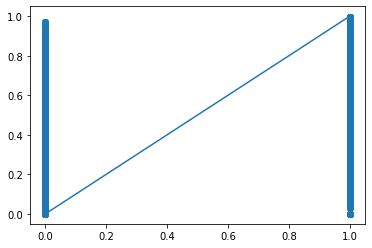

In [12]:
plt.plot(train[target], train[target])
plt.scatter(train[target], ctb_oof)

In [13]:
del train
del ctb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'CatB feature importances')

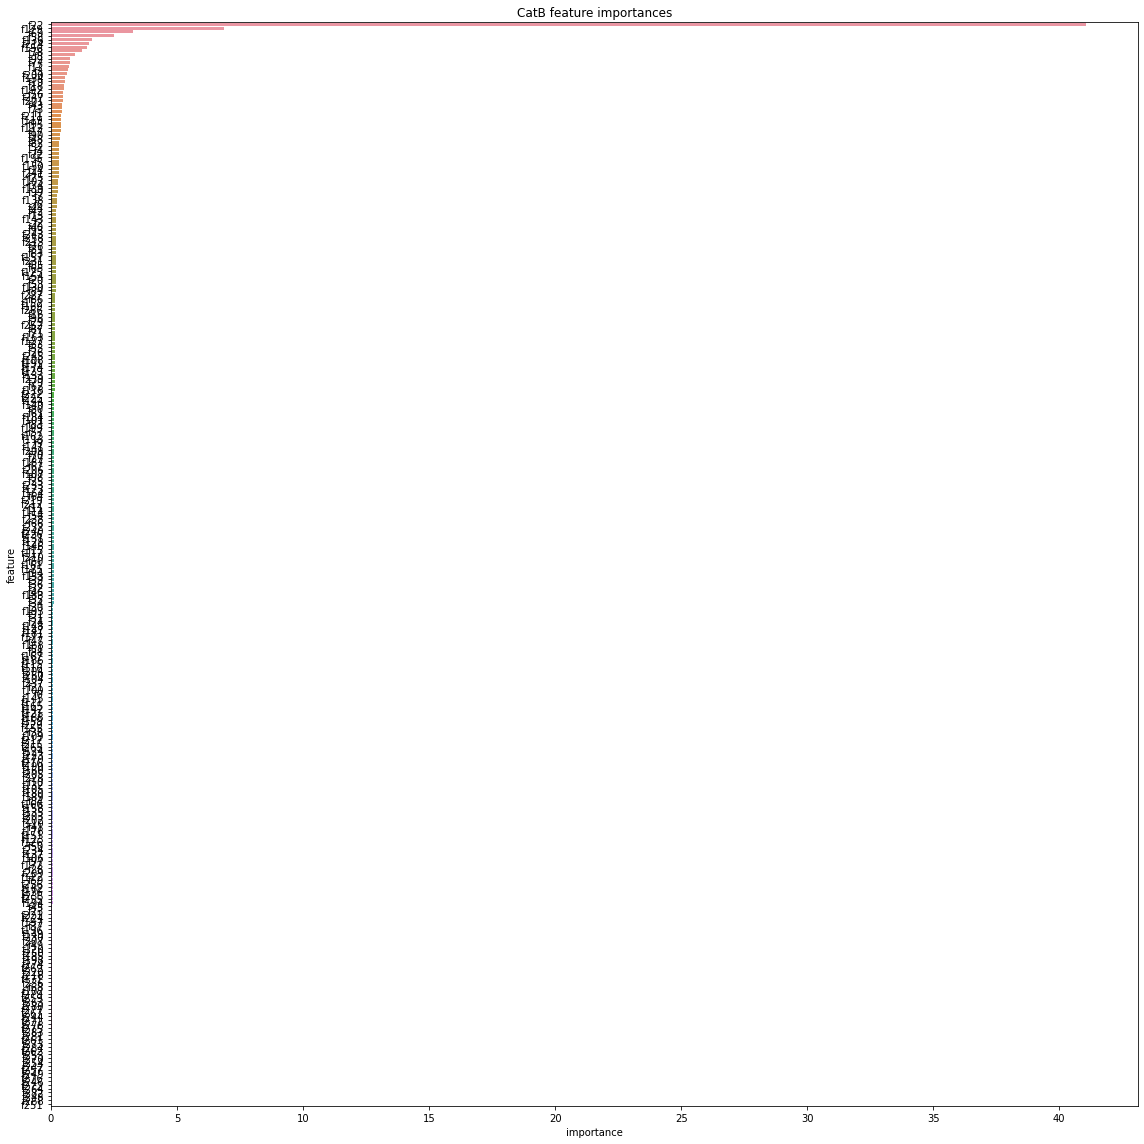

In [14]:
order = list(ctb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=ctb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("CatB feature importances")

# Submission

In [15]:
submission[target] = ctb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.299771
1,1000001,0.104183
2,1000002,0.361689
3,1000003,0.342839
4,1000004,0.117195
...,...,...
499995,1499995,0.385529
499996,1499996,0.331719
499997,1499997,0.122252
499998,1499998,0.220037


# Log

seeds

2017 ver2 fold 0-2 ver3 fold 3-4
2018 ver4 fold 0-2 ver5 fold 3-4
2019 ver6 fold 0-2 ver7 fold 3-4
2020 ver8 fold 0-2 ver9 fold 3-4
2021 ver10 fold 0-2 ver11 fold 3-4
